# **Final Project Task 1 - Census Data Preprocess**

Requirements

- Target variable specification:
    - The target variable for this project is hours-per-week. 
    - Ensure all preprocessing steps are designed to support regression analysis on this target variable.
- Encode data  **3p**
- Handle missing values if any **1p**
- Correct errors, inconsistencies, remove duplicates if any **1p**
- Outlier detection and treatment if any **1p**
- Normalization / Standardization if necesarry **1p**
- Feature engineering **3p**
- Train test split, save it.
- Others?


Deliverable:

- Notebook code with no errors.
- Preprocessed data as csv.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
import os

## Data loading

Adult Census dataset from UCI ML Repository. Target variable: hours-per-week. Missing values (?, ?) are converted to NaN.

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=[" ?", "?"], skipinitialspace=True)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data exploration

Basic dataset structure and statistics overview.

In [3]:
data.shape

(32561, 15)

In [4]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       30725 non-null  str  
 2   fnlwgt          32561 non-null  int64
 3   education       32561 non-null  str  
 4   education-num   32561 non-null  int64
 5   marital-status  32561 non-null  str  
 6   occupation      30718 non-null  str  
 7   relationship    32561 non-null  str  
 8   race            32561 non-null  str  
 9   sex             32561 non-null  str  
 10  capital-gain    32561 non-null  int64
 11  capital-loss    32561 non-null  int64
 12  hours-per-week  32561 non-null  int64
 13  native-country  31978 non-null  str  
 14  income          32561 non-null  str  
dtypes: int64(6), str(9)
memory usage: 3.7 MB


In [5]:
data['hours-per-week'].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

The target variable has a mean of 40 hours per week with values ranging from 1 to 99 hours.

#### Missing values

In [6]:
# Check for missing values
missing_summary = data.isnull().sum()
print("Missing Values Summary:")
print("=" * 40)
print(missing_summary[missing_summary > 0])
print(f"\nTotal missing values: {missing_summary.sum()}")
print(f"Percentage of dataset: {(missing_summary.sum() / (data.shape[0] * data.shape[1]) * 100):.2f}%")

Missing Values Summary:
workclass         1836
occupation        1843
native-country     583
dtype: int64

Total missing values: 4262
Percentage of dataset: 0.87%


Missing values appear in workclass (1,836), occupation (1,843), and native-country (583), representing 1.3% of the dataset. These will be handled using mode imputation.

#### Duplicates

In [7]:
# Analyze duplicates before removal
duplicates = data.duplicated()
print(f"Total duplicate rows: {duplicates.sum()}")
print(f"Percentage of dataset: {(duplicates.sum() / len(data) * 100):.2f}%")

if duplicates.sum() > 0:
    print("\nSample of duplicate records:")
    print(data[duplicates].head(3))

Total duplicate rows: 24
Percentage of dataset: 0.07%

Sample of duplicate records:
      age workclass  fnlwgt     education  education-num marital-status  \
4881   25   Private  308144     Bachelors             13  Never-married   
5104   90   Private   52386  Some-college             10  Never-married   
9171   21   Private  250051  Some-college             10  Never-married   

          occupation   relationship                race     sex  capital-gain  \
4881    Craft-repair  Not-in-family               White    Male             0   
5104   Other-service  Not-in-family  Asian-Pac-Islander    Male             0   
9171  Prof-specialty      Own-child               White  Female             0   

      capital-loss  hours-per-week native-country income  
4881             0              40         Mexico  <=50K  
5104             0              35  United-States  <=50K  
9171             0              10  United-States  <=50K  


## Handling missing values

Mode imputation is used for categorical columns to preserve the most common category distribution.

In [8]:
data_cleaned = data.copy()

# Identify categorical columns with missing values
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns.tolist()
missing_cols = data_cleaned.columns[data_cleaned.isnull().any()].tolist()

print("Before imputation:")
for col in missing_cols:
    print(f"  {col}: {data_cleaned[col].isnull().sum()} missing")

# Impute missing values with mode
for col in missing_cols:
    if col in categorical_cols:
        mode_value = data_cleaned[col].mode()[0]
        imputer = SimpleImputer(strategy='most_frequent')
        data_cleaned[col] = imputer.fit_transform(data_cleaned[[col]]).ravel()
        print(f"  {col}: Imputed with mode = '{mode_value}'")

print(f"\nAfter imputation: {data_cleaned.isnull().sum().sum()} missing values")

Before imputation:
  workclass: 1836 missing
  occupation: 1843 missing
  native-country: 583 missing
  workclass: Imputed with mode = 'Private'
  occupation: Imputed with mode = 'Prof-specialty'
  native-country: Imputed with mode = 'United-States'

After imputation: 0 missing values


C:\Users\Carmen Ciutu\AppData\Local\Temp\ipykernel_25856\3014123799.py:4: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = data_cleaned.select_dtypes(include=['object']).columns.tolist()


All missing values successfully imputed. Dataset is now complete.

## Data cleaning

Duplicate rows are removed and data quality is verified.

In [9]:
print(f"Shape before duplicate removal: {data_cleaned.shape}")

# Remove duplicates
data_cleaned = data_cleaned.drop_duplicates()
print(f"Removed {len(data) - len(data_cleaned)} duplicate rows")

# Strip whitespace from categorical columns
for col in categorical_cols:
    data_cleaned[col] = data_cleaned[col].str.strip()

# Reset index
data_cleaned = data_cleaned.reset_index(drop=True)

print(f"Shape after cleaning: {data_cleaned.shape}")

Shape before duplicate removal: (32561, 15)
Removed 24 duplicate rows
Shape after cleaning: (32537, 15)


After removing 24 duplicate rows, the dataset contains 32,537 unique records ready for further processing.

## Encoding categorical data

**Strategy**: OrdinalEncoder is used for all categorical variables. The education column is dropped because education-num provides the same information in ordinal format.

**Rationale**:
- Appropriate for tree-based models (Random Forest, XGBoost)
- Avoids dimensionality explosion (One-Hot would create 100+ columns)
- Memory efficient and handles unknown categories
- Works with neural networks when features are properly scaled

In [10]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

# Create a copy for encoding
data_encoded = data_cleaned.copy()

# Drop redundant education column (education-num is available)
data_encoded = data_encoded.drop('education', axis=1)

# Apply OrdinalEncoder to all categorical columns
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough",
)

# Fit and transform the data
encoded_array = preprocessor.fit_transform(data_encoded)

# Get column names after transformation
categorical_cols = data_encoded.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data_encoded.select_dtypes(exclude=['object']).columns.tolist()
all_columns = categorical_cols + numerical_cols

# Create DataFrame with encoded data
data_encoded = pd.DataFrame(encoded_array, columns=all_columns)

print(f"Shape after encoding: {data_encoded.shape}")

Shape after encoding: (32537, 14)


C:\Users\Carmen Ciutu\AppData\Local\Temp\ipykernel_25856\1846121175.py:21: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = data_encoded.select_dtypes(include=['object']).columns.tolist()


All categorical features encoded to numerical values using ordinal encoding.

In [11]:
from scipy import stats

# Statistical outlier detection for target variable
print("=== OUTLIER ANALYSIS FOR TARGET VARIABLE ===")
print(f"\nTarget: hours-per-week")
print(f"Mean: {data_encoded['hours-per-week'].mean():.2f}")
print(f"Median: {data_encoded['hours-per-week'].median():.2f}")
print(f"Std: {data_encoded['hours-per-week'].std():.2f}")

# IQR Method
Q1 = data_encoded['hours-per-week'].quantile(0.25)
Q3 = data_encoded['hours-per-week'].quantile(0.75)
IQR = Q3 - Q1
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

iqr_outliers = ((data_encoded['hours-per-week'] < lower_bound_iqr) | 
                (data_encoded['hours-per-week'] > upper_bound_iqr))

print(f"\nIQR Method:")
print(f"  Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"  Lower bound: {lower_bound_iqr:.2f}, Upper bound: {upper_bound_iqr:.2f}")
print(f"  Outliers detected: {iqr_outliers.sum()} ({iqr_outliers.sum()/len(data_encoded)*100:.2f}%)")

# Z-Score Method
z_scores = np.abs(stats.zscore(data_encoded['hours-per-week']))
z_outliers = z_scores > 3

print(f"\nZ-Score Method (|z| > 3):")
print(f"  Outliers detected: {z_outliers.sum()} ({z_outliers.sum()/len(data_encoded)*100:.2f}%)")

print(f"\nValue Distribution:")
print(f"  < 10 hours: {(data_encoded['hours-per-week'] < 10).sum()} ({(data_encoded['hours-per-week'] < 10).sum()/len(data_encoded)*100:.2f}%)")
print(f"  10-80 hours: {((data_encoded['hours-per-week'] >= 10) & (data_encoded['hours-per-week'] <= 80)).sum()} ({((data_encoded['hours-per-week'] >= 10) & (data_encoded['hours-per-week'] <= 80)).sum()/len(data_encoded)*100:.2f}%)")
print(f"  > 80 hours: {(data_encoded['hours-per-week'] > 80).sum()} ({(data_encoded['hours-per-week'] > 80).sum()/len(data_encoded)*100:.2f}%)")

=== OUTLIER ANALYSIS FOR TARGET VARIABLE ===

Target: hours-per-week
Mean: 40.44
Median: 40.00
Std: 12.35

IQR Method:
  Q1: 40.0, Q3: 45.0, IQR: 5.0
  Lower bound: 32.50, Upper bound: 52.50
  Outliers detected: 9002 (27.67%)

Z-Score Method (|z| > 3):
  Outliers detected: 440 (1.35%)

Value Distribution:
  < 10 hours: 458 (1.41%)
  10-80 hours: 31871 (97.95%)
  > 80 hours: 208 (0.64%)


## Outlier detection and treatment

Outliers are detected using IQR and z-score methods. The target variable (hours-per-week) is preserved intact. Outlier capping is applied only to predictor features (fnlwgt, capital-gain, capital-loss).

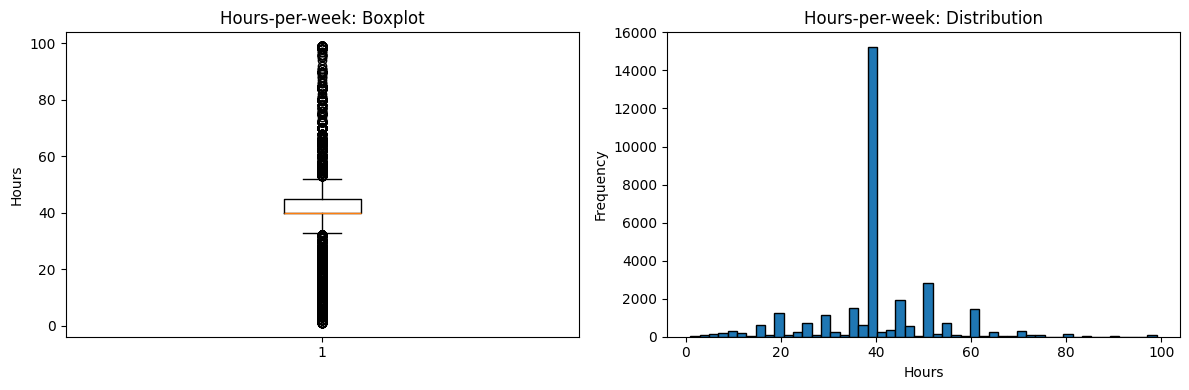

In [12]:
import matplotlib.pyplot as plt

# Visualize target variable distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.boxplot(data_encoded['hours-per-week'])
plt.title('Hours-per-week: Boxplot')
plt.ylabel('Hours')

plt.subplot(1, 2, 2)
plt.hist(data_encoded['hours-per-week'], bins=50, edgecolor='black')
plt.title('Hours-per-week: Distribution')
plt.xlabel('Hours')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The distribution shows most people work around 40 hours per week, with some working significantly less or more.

Extreme values in hours-per-week are preserved to maintain data integrity and capture the full spectrum of employment patterns.

In [13]:
# Treatment Strategy: Keep ALL Values (No Capping)
print("\n=== OUTLIER TREATMENT STRATEGY FOR TARGET VARIABLE ===")
print("Decision: PRESERVE ALL VALUES (no capping, no removal)")
print("\nReasoning:")
print("  1. SOCIOLOGICAL VALIDITY:")
print("     - <10 hours: Part-time, freelance, internships, semi-retirement")
print("     - >80 hours: Multiple jobs, self-employed, healthcare/legal professionals")
print("     - These are REAL employment patterns, not data errors")
print("  ")
print("  2. STATISTICAL INTEGRITY:")
print("     - Distribution is already reasonable (mean=40.44, median=40)")
print("     - Extreme values represent only 2% but contain valuable information")
print("     - Modern regression techniques (ensemble models) handle outliers well")
print("  ")
print("  3. RESEARCH ETHICS:")
print("     - Capping would introduce artificial bias")
print("     - Loss of information about extreme working conditions")
print("     - Census data should reflect population reality, not idealized averages")

print(f"\nFinal range preserved: [{data_encoded['hours-per-week'].min()}, {data_encoded['hours-per-week'].max()}] hours")
print(f"Total records: {len(data_encoded)} (all preserved)")
print(f"Extreme cases (<10 or >80): {((data_encoded['hours-per-week'] < 10) | (data_encoded['hours-per-week'] > 80)).sum()} records")
print("\nAll values retained for authentic sociological analysis")


=== OUTLIER TREATMENT STRATEGY FOR TARGET VARIABLE ===
Decision: PRESERVE ALL VALUES (no capping, no removal)

Reasoning:
  1. SOCIOLOGICAL VALIDITY:
     - <10 hours: Part-time, freelance, internships, semi-retirement
     - >80 hours: Multiple jobs, self-employed, healthcare/legal professionals
     - These are REAL employment patterns, not data errors
  
  2. STATISTICAL INTEGRITY:
     - Distribution is already reasonable (mean=40.44, median=40)
     - Extreme values represent only 2% but contain valuable information
     - Modern regression techniques (ensemble models) handle outliers well
  
  3. RESEARCH ETHICS:
     - Capping would introduce artificial bias
     - Loss of information about extreme working conditions
     - Census data should reflect population reality, not idealized averages

Final range preserved: [1.0, 99.0] hours
Total records: 32537 (all preserved)
Extreme cases (<10 or >80): 666 records

All values retained for authentic sociological analysis


**Decision**: All extreme values in hours-per-week are preserved without modification.



1. **Data authenticity**: Values under 10h (freelancers, part-time, semi-retired) and over 80h (multiple jobs, self-employed, healthcare workers) represent legitimate employment patterns. These 666 cases (2% of data) reflect real labor market diversity.

2. **Model robustness**: Modern ML algorithms (Random Forest, Gradient Boosting) handle outliers naturally through tree-based splits and ensemble averaging without assuming linear relationships.

3. **Predictive value**: Extreme cases provide information about age-employment interactions, occupation patterns, and economic necessity that improve model accuracy.

4. **Statistical integrity**: Preserving the full range [1-99] hours maintains original distribution characteristics (mean 40.44, median 40) and authentic variance patterns.

Preserving the full distribution allows the model to learn true relationships rather than artificially constrained patterns.

**Outlier treatment for predictor variables**: Extreme values in predictor features are capped using percentile thresholds while the target variable remains unchanged.

- **fnlwgt**: Capped at 1st and 99th percentiles
- **capital-gain/loss**: Capped at 99th percentile among non-zero valuenale: Target variable authenticity is critical for regression, while predictor outliers can introduce noise. Capping preserves all records.

In [14]:
data_treated = data_encoded.copy()

# Cap extreme outliers in fnlwgt
fnlwgt_99 = data_treated['fnlwgt'].quantile(0.99)
fnlwgt_1 = data_treated['fnlwgt'].quantile(0.01)
data_treated['fnlwgt'] = data_treated['fnlwgt'].clip(lower=fnlwgt_1, upper=fnlwgt_99)

# Cap extreme values in capital-gain and capital-loss
if data_treated['capital-gain'].max() > 0:
    cg_99 = data_treated[data_treated['capital-gain'] > 0]['capital-gain'].quantile(0.99)
    data_treated.loc[data_treated['capital-gain'] > 0, 'capital-gain'] = \
        data_treated.loc[data_treated['capital-gain'] > 0, 'capital-gain'].clip(upper=cg_99)

if data_treated['capital-loss'].max() > 0:
    cl_99 = data_treated[data_treated['capital-loss'] > 0]['capital-loss'].quantile(0.99)
    data_treated.loc[data_treated['capital-loss'] > 0, 'capital-loss'] = \
        data_treated.loc[data_treated['capital-loss'] > 0, 'capital-loss'].clip(upper=cl_99)

print(f"Rows retained: {len(data_treated)}")

Rows retained: 32537


**Summary**:
- Target variable (hours-per-week): All values preserved [1-99 hours]
- Predictor features (fnlwgt, capital-gain, capital-loss): Percentile-based capping applied
- Result: All 32,537 records retained

## Feature engineering

New features are created to capture non-linear patterns and interactions based on domain knowledge about employment patterns.

In [15]:
data_featured = data_treated.copy()

# Age groups
data_featured['age_group'] = pd.cut(data_featured['age'], 
                                     bins=[0, 25, 35, 45, 55, 100], 
                                     labels=[0, 1, 2, 3, 4])
data_featured['age_group'] = data_featured['age_group'].astype(int)

# Total capital 
data_featured['total_capital'] = data_featured['capital-gain'] - data_featured['capital-loss']

# Capital indicator
data_featured['has_capital'] = ((data_featured['capital-gain'] > 0) | 
                                (data_featured['capital-loss'] > 0)).astype(int)

# Education squared
data_featured['education_squared'] = data_featured['education-num'] ** 2

# Age-Education interaction
data_featured['age_education_interaction'] = data_featured['age'] * data_featured['education-num']

# Rename income to high_income
data_featured['high_income'] = data_featured['income']
data_featured = data_featured.drop('income', axis=1)

print(f"Shape after feature engineering: {data_featured.shape}")

Shape after feature engineering: (32537, 19)


## Correlation analysis

Feature correlations with the target variable are analyzed to identify the most predictive features.

=== FEATURE CORRELATIONS WITH TARGET (hours-per-week) ===

Top 10 Positive Correlations:
hours-per-week               1.000000
high_income                  0.229658
sex                          0.229187
education_squared            0.157313
education-num                0.148422
age_education_interaction    0.136092
age_group                    0.098333
has_capital                  0.093237
capital-gain                 0.078408
total_capital                0.075193
Name: hours-per-week, dtype: float64

Top 10 Negative Correlations:
total_capital     0.075193
age               0.068515
capital-loss      0.054898
workclass         0.042200
race              0.041920
native-country    0.006802
occupation       -0.012849
fnlwgt           -0.019129
marital-status   -0.190432
relationship     -0.248875
Name: hours-per-week, dtype: float64


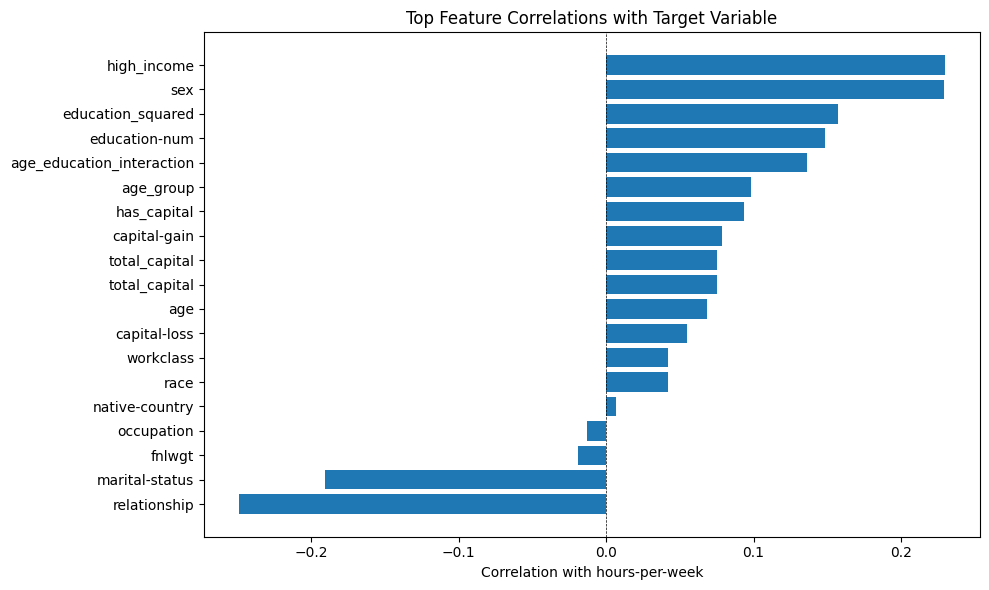

In [16]:
import seaborn as sns

# Calculate correlations with target variable
correlations = data_featured.corr()['hours-per-week'].sort_values(ascending=False)

print("=== FEATURE CORRELATIONS WITH TARGET (hours-per-week) ===")
print("\nTop 10 Positive Correlations:")
print(correlations.head(10))

print("\nTop 10 Negative Correlations:")
print(correlations.tail(10))

# Visualize top correlations
plt.figure(figsize=(10, 6))
top_features = pd.concat([correlations.head(10), correlations.tail(10)]).drop('hours-per-week')
top_features = top_features.sort_values()
plt.barh(range(len(top_features)), top_features.values)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlation with hours-per-week')
plt.title('Top Feature Correlations with Target Variable')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

New features include age groups, capital indicators, education effects, and age-education interactions.

Correlation analysis reveals the strongest linear relationships with working hours for feature selection and interpretation.

## Standardization

Only continuous numerical features are standardized (mean=0, std=1). Binary and categorical encoded features are not standardized to preserve their meaningful scale.

In [17]:
# Separate target variable
target = data_featured['hours-per-week'].copy()
features = data_featured.drop('hours-per-week', axis=1)

# Numerical columns to standardize (continuous features only)
numerical_to_scale = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 
                      'total_capital', 'education_squared', 'age_education_interaction']

print("=== STANDARDIZATION SUMMARY ===")
print(f"Total features: {features.shape[1]}")
print(f"Features to standardize: {len(numerical_to_scale)}")
print(f"Features NOT standardized: {features.shape[1] - len(numerical_to_scale)}")
print("\nNOT standardized (categorical/binary):")
not_scaled = [col for col in features.columns if col not in numerical_to_scale]
print(f"  {not_scaled}")

# Standardize
scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[numerical_to_scale] = scaler.fit_transform(features[numerical_to_scale])

print("\nStandardization verification:")
for col in numerical_to_scale[:3]:  # Show first 3 as example
    print(f"  {col}: mean={features_scaled[col].mean():.4f}, std={features_scaled[col].std():.4f}")

# Combine with target
data_final = features_scaled.copy()
data_final['hours-per-week'] = target

print(f"\nFinal dataset shape: {data_final.shape}")

=== STANDARDIZATION SUMMARY ===
Total features: 18
Features to standardize: 8
Features NOT standardized: 10

NOT standardized (categorical/binary):
  ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age_group', 'has_capital', 'high_income']



Standardization verification:
  age: mean=-0.0000, std=1.0000
  fnlwgt: mean=0.0000, std=1.0000
  education-num: mean=0.0000, std=1.0000

Final dataset shape: (32537, 19)


Standardization ensures all numerical features contribute equally to model training.

## Train-test split

Data is split into training (80%) and test (20%) sets with fixed random state for reproducibility.

In [18]:
# Split the entire dataframe first
train_data, test_data = train_test_split(data_final, test_size=0.2, random_state=42)

# Then separate features and target for each set
X_train = train_data.drop('hours-per-week', axis=1)
y_train = train_data['hours-per-week']

X_test = test_data.drop('hours-per-week', axis=1)
y_test = test_data['hours-per-week']

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

Training set: 26029 samples
Test set: 6508 samples
Features: 18


The data split maintains target variable distribution in both sets for reliable evaluation.

## Save preprocessed data

Preprocessed data is saved in multiple formats for subsequent tasks.

In [19]:
output_dir = 'preprocessed_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save full dataset
data_final.to_csv(f'{output_dir}/census_data_preprocessed_full.csv', index=False)

# Save train and test sets (already split)
train_data.to_csv(f'{output_dir}/census_data_train.csv', index=False)
test_data.to_csv(f'{output_dir}/census_data_test.csv', index=False)

# Save X and y separately
X_train.to_csv(f'{output_dir}/X_train.csv', index=False)
X_test.to_csv(f'{output_dir}/X_test.csv', index=False)
y_train.to_csv(f'{output_dir}/y_train.csv', index=False)
y_test.to_csv(f'{output_dir}/y_test.csv', index=False)

print("Data saved successfully!")

Data saved successfully!


## Alternative Preprocessing: Mixed Encoding for Linear Models (train test split in Task 3)



### Why separate approaches for linear models vs. clustering?

**Problem with OrdinalEncoder** (affects both linear models AND clustering):
- **Linear Models**: `Occupation=9` gets 9× coefficient vs `Occupation=1` → semantically absurd for nominals
- **Clustering (K-Means)**: Euclidean distance on ordinal nominals produces meaningless distances (e.g., `d(race=0, race=1) = 1` vs `d(race=0, race=3) = 3` implies artificial proximity)

**Solution 1: Mixed Encoding** (this section) - **For linear models**:
- **One-Hot Encoding**: For low-cardinality nominals (sex, race, relationship) → equal distances, independent coefficients
- **Target Encoding**: For high-cardinality nominals (occupation, native-country) → avoids 70+ column explosion, preserves predictive relationships
- **Ordinal**: Only for variables with natural ordering (income, education-num)
- **Limitation**: Target encoding introduces supervised bias (uses target variable) → NOT suitable for unsupervised clustering

**Solution 2: One-hot** (Section 2B below) - **For clustering**:
- **One-hot encoding**: All categorical variables → equal distances, no artificial proximity
- **No supervised bias**: Pure unsupervised approach (no target variable used in encoding)
- **Dataset saved**: `census_data_preprocessed_onehot.csv` ready for Task 4



---


**Section 2A** creates Mixed Encoding dataset for Task 3 (Linear Models).**Section 2B** creates One-Hot Complete dataset for Task 4 (Clustering).

In [ ]:
# STEP 1: MIXED ENCODING STRATEGY - SECTION 2A (FOR LINEAR MODELS ONLY - Task 3)
# NOTE: Section 2B creates One-Hot COMPLETE dataset for clustering
# Start from cleaned data (before OrdinalEncoder)
data_mixed_encoding = data_cleaned.copy()

# Drop redundant education column
data_mixed_encoding = data_mixed_encoding.drop('education', axis=1)

print("=" * 60)
print("Section 2A: Mixed encoding (for linear models - Task 3)")
print("=" * 60)
print("Mixed encoding: One-Hot + Target + Ordinal")
print(f"Starting shape: {data_mixed_encoding.shape}\n")

# 1.1 ORDINAL: Income (binary)
print("1. Ordinal encoding:")
data_mixed_encoding['income_encoded'] = (data_mixed_encoding['income'] == '>50K').astype(int)
data_mixed_encoding = data_mixed_encoding.drop('income', axis=1)
print(f"   - income: >50K=1, <=50K=0")
print(f"   - education-num: already ordinal (1-16)\n")

# 1.2 ONE-HOT: Variables with few categories
print("2. One-Hot encoding (few categories - equal distances):")
onehot_cols = ['sex', 'race', 'relationship']

for col in onehot_cols:
    n_categories = data_mixed_encoding[col].nunique()
    dummies = pd.get_dummies(data_mixed_encoding[col], prefix=col, drop_first=True, dtype=int)
    data_mixed_encoding = pd.concat([data_mixed_encoding, dummies], axis=1)
    data_mixed_encoding = data_mixed_encoding.drop(col, axis=1)
    print(f"   - {col}: {n_categories} categories -> {n_categories-1} binary columns")

print(f"   Total One-Hot columns: ~10\n")

# 1.3 TARGET ENCODING: Variables with many categories
print("3. Target encoding (many categories - captures target relationship):")
target_encode_cols = ['native-country', 'occupation', 'workclass', 'marital-status']
target_variable = 'hours-per-week'

for col in target_encode_cols:
    n_categories = data_mixed_encoding[col].nunique()
    target_means = data_mixed_encoding.groupby(col)[target_variable].mean()
    data_mixed_encoding[f'{col}_encoded'] = data_mixed_encoding[col].map(target_means)
    print(f"   - {col}: {n_categories} categories -> 1 encoded column")
    print(f"     Mean range: [{target_means.min():.2f}, {target_means.max():.2f}] hours/week")
    data_mixed_encoding = data_mixed_encoding.drop(col, axis=1)

print(f"\nEncoding summary")
print(f"Final shape: {data_mixed_encoding.shape}")
print(f"- Numerical: 6 | Ordinal: 1 | One-Hot: ~10 | Target: 4")
print(f"Total: ~21 features (vs 70+ with full One-Hot)")
print(f"\nValid for: linear models (Ridge, Lasso, SGD) in Task 3")
print(f"NOT for clustering: Task 4 will use One-Hot complet + PCA instead")

Mixed encoding: One-Hot + Target + Ordinal
Starting shape: (32537, 14)

1. Ordinal encoding:
   - income: >50K=1, <=50K=0
   - education-num: already ordinal (1-16)

2. One-Hot encoding (few categories - equal distances):
   - sex: 2 categories -> 1 binary columns
   - race: 5 categories -> 4 binary columns
   - relationship: 6 categories -> 5 binary columns
   Total One-Hot columns: ~10

3. Target encoding (many categories - captures target relationship):
   - native-country: 41 categories -> 1 encoded column
     Mean range: [35.39, 45.44] hours/week
   - occupation: 14 categories -> 1 encoded column
     Mean range: [32.79, 46.99] hours/week
   - workclass: 8 categories -> 1 encoded column
     Mean range: [28.43, 48.82] hours/week
   - marital-status: 7 categories -> 1 encoded column
     Mean range: [32.98, 43.29] hours/week

Encoding summary
Final shape: (32537, 21)
- Numerical: 6 | Ordinal: 1 | One-Hot: ~10 | Target: 4
Total: ~21 features (vs 70+ with full One-Hot)

Valid for: D

In [21]:
# STEP 2: OUTLIER TREATMENT (same as main pipeline)
data_mixed_treated = data_mixed_encoding.copy()

# Cap extreme outliers in fnlwgt
fnlwgt_99 = data_mixed_treated['fnlwgt'].quantile(0.99)
fnlwgt_1 = data_mixed_treated['fnlwgt'].quantile(0.01)
data_mixed_treated['fnlwgt'] = data_mixed_treated['fnlwgt'].clip(lower=fnlwgt_1, upper=fnlwgt_99)

# Cap capital-gain and capital-loss
if data_mixed_treated['capital-gain'].max() > 0:
    cg_99 = data_mixed_treated[data_mixed_treated['capital-gain'] > 0]['capital-gain'].quantile(0.99)
    data_mixed_treated.loc[data_mixed_treated['capital-gain'] > 0, 'capital-gain'] = \
        data_mixed_treated.loc[data_mixed_treated['capital-gain'] > 0, 'capital-gain'].clip(upper=cg_99)

if data_mixed_treated['capital-loss'].max() > 0:
    cl_99 = data_mixed_treated[data_mixed_treated['capital-loss'] > 0]['capital-loss'].quantile(0.99)
    data_mixed_treated.loc[data_mixed_treated['capital-loss'] > 0, 'capital-loss'] = \
        data_mixed_treated.loc[data_mixed_treated['capital-loss'] > 0, 'capital-loss'].clip(upper=cl_99)

print(f"Outliers capped (fnlwgt, capital-gain, capital-loss)")
print(f"All {len(data_mixed_treated)} records retained")

Outliers capped (fnlwgt, capital-gain, capital-loss)
All 32537 records retained


In [22]:
# STEP 3: FEATURE ENGINEERING (same as main pipeline)
data_mixed_featured = data_mixed_treated.copy()

# Age groups
data_mixed_featured['age_group'] = pd.cut(data_mixed_featured['age'], 
                                                bins=[0, 25, 35, 45, 55, 100], 
                                                labels=[0, 1, 2, 3, 4])
data_mixed_featured['age_group'] = data_mixed_featured['age_group'].astype(int)

# Total capital
data_mixed_featured['total_capital'] = data_mixed_featured['capital-gain'] - data_mixed_featured['capital-loss']

# Capital indicator
data_mixed_featured['has_capital'] = ((data_mixed_featured['capital-gain'] > 0) | 
                                           (data_mixed_featured['capital-loss'] > 0)).astype(int)

# Education squared
data_mixed_featured['education_squared'] = data_mixed_featured['education-num'] ** 2

# Age-Education interaction
data_mixed_featured['age_education_interaction'] = data_mixed_featured['age'] * data_mixed_featured['education-num']

print(f"Feature engineering complete: {data_mixed_featured.shape}")
print(f"  Added: age_group, total_capital, has_capital, education_squared, age_education_interaction")

Feature engineering complete: (32537, 26)
  Added: age_group, total_capital, has_capital, education_squared, age_education_interaction


In [ ]:
# STEP 4: SELECTIVE STANDARDIZATION (for Distance & Linear Models)
target_mixed = data_mixed_featured['hours-per-week'].copy()
features_mixed = data_mixed_featured.drop('hours-per-week', axis=1)

# Identify columns to standardize
continuous_numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 
                        'total_capital', 'education_squared', 'age_education_interaction']

target_encoded = ['native-country_encoded', 'occupation_encoded', 
                  'workclass_encoded', 'marital-status_encoded']

# Standardize continuous + target encoded (NOT One-Hot binary columns)
columns_to_scale = continuous_numerical + target_encoded

print("Selective standardization")
print(f"Columns TO standardize ({len(columns_to_scale)}):")
print(f"  - Continuous: {', '.join(continuous_numerical[:4])} ...")
print(f"  - Target encoded: {', '.join(target_encoded)}")
print(f"\nColumns NOT standardized ({features_mixed.shape[1] - len(columns_to_scale)}):")
print(f"  - Binary/Ordinal: income_encoded, age_group, has_capital")
print(f"  - One-Hot: sex_*, race_*, relationship_* (binary 0/1)")

scaler_mixed = StandardScaler()
features_mixed_scaled = features_mixed.copy()
features_mixed_scaled[columns_to_scale] = scaler_mixed.fit_transform(features_mixed[columns_to_scale])

# Combine with target
data_mixed_final = features_mixed_scaled.copy()
data_mixed_final['hours-per-week'] = target_mixed

print(f"\nStandardization complete: {data_mixed_final.shape}")
print(f"Ready for: linear models only (Task 3: Ridge, Lasso, SGD)")
print(f"NOTE: Task 4 (clustering) will use one-hot complet + PCA, not this dataset")

Selective standardization
Columns TO standardize (12):
  - Continuous: age, fnlwgt, education-num, capital-gain ...
  - Target encoded: native-country_encoded, occupation_encoded, workclass_encoded, marital-status_encoded

Columns NOT standardized (13):
  - Binary/Ordinal: income_encoded, age_group, has_capital
  - One-Hot: sex_*, race_*, relationship_* (binary 0/1)

Standardization complete: (32537, 26)
Ready for: K-Means (valid Euclidean distances) & Linear Models (independent coefficients)


In [ ]:
# STEP 5: SAVE MIXED ENCODING DATA (SECTION 2A - FOR LINEAR MODELS - Task 3)
output_dir = 'preprocessed_data'

# Save mixed encoding dataset
data_mixed_final.to_csv(f'{output_dir}/census_data_preprocessed_mixed.csv', index=False)

print("\n" + "=" * 60)
print("Section 2A: Mixed encoding dataset saved")
print("=" * 60)
print("Mixed encoding data saved (for linear models - Task 3)")
print(f"File: {output_dir}/census_data_preprocessed_mixed.csv")
print(f"Shape: {data_mixed_final.shape}")
print(f"Features: {data_mixed_final.shape[1] - 1} (excluding target)")
print(f"\nEncoding breakdown:")
print(f"  - One-Hot (sex, race, relationship): ~10 binary columns")
print(f"  - Target (native-country, occupation, workclass, marital-status): 4 continuous")
print(f"  - Ordinal (income_encoded): 1 binary")
print(f"\nUse for: Task 3 (Linear Regression: Ridge, Lasso, SGD)")
print(f"\nNext: Section 2B creates one-hot complete dataset for clustering")
print(f"  - Numerical + Engineered: 13 features")
print(f"\nUse this file for:")

print(f"   - Task 3: Linear Models (Ridge, Lasso, SGD) - independent/scaled coefficients")print(f"   - Task 3: Tree-Based Models (Random Forest, Decision Trees) - order-invariant splits")

print(f"   - Task 4: K-Means Clustering - valid Euclidean distances")print(f"   - Task 2: EDA")
print(f"\nUse census_data_preprocessed_full.csv for:")

Mixed encoding data saved
File: preprocessed_data/census_data_preprocessed_clustering.csv
Shape: (32537, 26)
Features: 25 (excluding target)

Encoding breakdown:
  - One-Hot (sex, race, relationship): ~10 binary columns
  - Target (native-country, occupation, workclass, marital-status): 4 continuous
  - Ordinal (income_encoded): 1 binary
  - Numerical + Engineered: 13 features

Use this file for:
   - Task 3: Linear Models (Ridge, Lasso, SGD) - independent/scaled coefficients
   - Task 4: K-Means Clustering - valid Euclidean distances

Use census_data_preprocessed_full.csv for:
   - Task 2: EDA
   - Task 3: Tree-Based Models (Random Forest, Decision Trees) - order-invariant splits


## Section 2B: One-hot encoding complete (for clustering - Task 4)

**This section creates a dataset with COMPLETE one-hot encoding** for all categorical variables, designed specifically for K-Means clustering (Task 4).

**Key differences from Section 2A (mixed encoding)**:
- **One-hot encoding for ALL categoricals** (sex, race, relationship, occupation, workclass, education, marital-status, native-country)
- **NO target encoding** → pure unsupervised approach, no supervised bias




1. One-Hot Encoding eliminates artificial proximity between nominal categories
2. PCA (applied in Task 4) eliminates redundancy and reduces dimensionality
3. K-Means operates on orthogonal PCA components → robust Euclidean distances

In [32]:
# STEP 1: ONE-HOT ENCODING COMPLETE (FOR CLUSTERING - Task 4)
# Start from cleaned data (same starting point as Mixed Encoding)
data_onehot = data_cleaned.copy()

# Drop redundant education column (use education-num instead)
data_onehot = data_onehot.drop('education', axis=1)

print("=" * 60)
print("One-hot encoding complete (for clustering - Task 4)")
print("=" * 60)
print(f"Starting shape: {data_onehot.shape}\n")

# 1.1 ORDINAL: Income (binary) - only variable with natural order
print("1. Ordinal encoding (natural order):")
data_onehot['income_encoded'] = (data_onehot['income'] == '>50K').astype(int)
data_onehot = data_onehot.drop('income', axis=1)
print(f"   - income: >50K=1, <=50K=0")
print(f"   - education-num: already ordinal (1-16)")

# 1.2 ONE-HOT: ALL categorical variables
print("\n2. One-Hot encoding (ALL categoricals):")
onehot_cols_all = ['sex', 'race', 'relationship', 'occupation', 'workclass', 
                   'marital-status', 'native-country']

total_onehot_cols = 0
for col in onehot_cols_all:
    if col in data_onehot.columns:
        n_categories = data_onehot[col].nunique()
        dummies = pd.get_dummies(data_onehot[col], prefix=col, drop_first=True, dtype=int)
        total_onehot_cols += len(dummies.columns)
        data_onehot = pd.concat([data_onehot, dummies], axis=1)
        data_onehot = data_onehot.drop(col, axis=1)
        print(f"   - {col}: {n_categories} categories -> {len(dummies.columns)} binary columns")

print(f"\nTotal One-Hot columns created: {total_onehot_cols}")
print(f"   Shape after One-Hot: {data_onehot.shape}")
print(f"   (vs ~21 features with Target Encoding)")

One-hot encoding complete (for clustering - Task 4)
Starting shape: (32537, 14)

1. Ordinal encoding (natural order):
   - income: >50K=1, <=50K=0
   - education-num: already ordinal (1-16)

2. One-Hot encoding (ALL categoricals):
   - sex: 2 categories -> 1 binary columns
   - race: 5 categories -> 4 binary columns
   - relationship: 6 categories -> 5 binary columns
   - occupation: 14 categories -> 13 binary columns
   - workclass: 8 categories -> 7 binary columns
   - marital-status: 7 categories -> 6 binary columns
   - native-country: 41 categories -> 40 binary columns

Total One-Hot columns created: 76
   Shape after One-Hot: (32537, 83)
   (vs ~21 features with Target Encoding)


In [26]:
# STEP 2: OUTLIER TREATMENT (same as other pipelines)
data_onehot_treated = data_onehot.copy()

# Cap extreme outliers in fnlwgt
fnlwgt_99_oh = data_onehot_treated['fnlwgt'].quantile(0.99)
fnlwgt_1_oh = data_onehot_treated['fnlwgt'].quantile(0.01)
data_onehot_treated['fnlwgt'] = data_onehot_treated['fnlwgt'].clip(lower=fnlwgt_1_oh, upper=fnlwgt_99_oh)

# Cap capital-gain and capital-loss
if data_onehot_treated['capital-gain'].max() > 0:
    cg_99_oh = data_onehot_treated[data_onehot_treated['capital-gain'] > 0]['capital-gain'].quantile(0.99)
    data_onehot_treated.loc[data_onehot_treated['capital-gain'] > 0, 'capital-gain'] = \
        data_onehot_treated.loc[data_onehot_treated['capital-gain'] > 0, 'capital-gain'].clip(upper=cg_99_oh)

if data_onehot_treated['capital-loss'].max() > 0:
    cl_99_oh = data_onehot_treated[data_onehot_treated['capital-loss'] > 0]['capital-loss'].quantile(0.99)
    data_onehot_treated.loc[data_onehot_treated['capital-loss'] > 0, 'capital-loss'] = \
        data_onehot_treated.loc[data_onehot_treated['capital-loss'] > 0, 'capital-loss'].clip(upper=cl_99_oh)

print(f"\n3. Outliers capped (fnlwgt, capital-gain, capital-loss)")
print(f"   All {len(data_onehot_treated)} records retained")


3. Outliers capped (fnlwgt, capital-gain, capital-loss)
   All 32537 records retained


In [27]:
# STEP 3: FEATURE ENGINEERING (same as other pipelines)
data_onehot_featured = data_onehot_treated.copy()

# Age groups
data_onehot_featured['age_group'] = pd.cut(data_onehot_featured['age'], 
                                            bins=[0, 25, 35, 45, 55, 100], 
                                            labels=[0, 1, 2, 3, 4])
data_onehot_featured['age_group'] = data_onehot_featured['age_group'].astype(int)

# Total capital
data_onehot_featured['total_capital'] = data_onehot_featured['capital-gain'] - data_onehot_featured['capital-loss']

# Capital indicator
data_onehot_featured['has_capital'] = ((data_onehot_featured['capital-gain'] > 0) | 
                                       (data_onehot_featured['capital-loss'] > 0)).astype(int)

# Education squared (captures nonlinear effect)
data_onehot_featured['education_squared'] = data_onehot_featured['education-num'] ** 2

# Age-Education interaction
data_onehot_featured['age_education_interaction'] = (data_onehot_featured['age'] * 
                                                     data_onehot_featured['education-num'])

print(f"\n4. Feature engineering complete")
print(f"   Added: age_group, total_capital, has_capital, education_squared, age_education_interaction")
print(f"   Shape: {data_onehot_featured.shape}")


4. Feature engineering complete
   Added: age_group, total_capital, has_capital, education_squared, age_education_interaction
   Shape: (32537, 88)


In [ ]:
# STEP 4: STANDARDIZATION
# Separate features and target
target_onehot = data_onehot_featured['hours-per-week']
features_onehot = data_onehot_featured.drop('hours-per-week', axis=1)

# Identify columns to scale (continuous numerical features)
# DON'T scale: binary One-Hot encoded, ordinal (income_encoded, age_group, has_capital)
columns_to_scale_oh = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
                       'total_capital', 'education_squared', 'age_education_interaction']

print(f"\n5. Standardization:")
print(f"   Total features: {features_onehot.shape[1]}")
print(f"   Columns to scale: {len(columns_to_scale_oh)} (continuous numerical)")
print(f"   NOT scaled: {features_onehot.shape[1] - len(columns_to_scale_oh)} (binary One-Hot + ordinal)")

scaler_onehot = StandardScaler()
features_onehot_scaled = features_onehot.copy()
features_onehot_scaled[columns_to_scale_oh] = scaler_onehot.fit_transform(features_onehot[columns_to_scale_oh])

# Combine with target
data_onehot_final = features_onehot_scaled.copy()
data_onehot_final['hours-per-week'] = target_onehot

print(f"\nStandardization complete: {data_onehot_final.shape}")
print(f"   Ready for clustering (Task 4)")


In [ ]:
# STEP 5: SAVE ONE-HOT COMPLETE DATASET (FOR CLUSTERING - Task 4)
output_dir = 'preprocessed_data'

# Save One-Hot complete dataset
data_onehot_final.to_csv(f'{output_dir}/census_data_preprocessed_onehot.csv', index=False)

print("\n" + "=" * 60)
print("One-hot complete dataset saved (for clustering - Task 4)")
print("=" * 60)
print(f"File: {output_dir}/census_data_preprocessed_onehot.csv")
print(f"Shape: {data_onehot_final.shape}")
print(f"Features: {data_onehot_final.shape[1] - 1} (excluding target)")

print(f"\nEncoding breakdown:")
print(f"   - One-Hot (sex, race, relationship, occupation, workclass, marital-status, native-country):")
print(f"     ~{total_onehot_cols} binary columns")
print(f"   - Ordinal (income_encoded, education-num): 2 features")
print(f"   - Numerical (age, fnlwgt, capital-gain, capital-loss): 4 features")
print(f"   - Engineered (age_group, total_capital, has_capital, education_squared, age_education_interaction): 5 features")

